In [3]:
import math
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import statistics
%run Isolation_Template.ipynb
%run Agglomerative_Cluster_Template.ipynb

import pandas as pd
import numpy as np
#file path to credit card csv file
file_path = os.path.join(os.path.expanduser("~"), "Downloads", "creditcard.csv")
df = pd.read_csv(file_path) #read csv file as pandas object
CC_data = df.to_numpy() #CC_data will contain the Credit Card Fraud detection dataset as a numpy object

def runPipeline(dataset):
    params = {"features": [.1, .25, .5, 1], "percentOfData": [.1, .25, .50], "z-score": [-4, -4.2, -4.4, -4.6]}
    labels = np.array([arr[-1] for arr in dataset])   
    df = np.array([arr[:-1] for arr in dataset])       
    results1 = runTuneTest("IsolationForest", params, df, labels)
    print("Isolation Forest Grid Search CV:")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    for i in range(len(results1)):
        print("Parameters:")
        print(results1[i][0])
        print("Confusion Matrix Data:")
        # for j in results1[i][2]:
        #     print(j)
        print(results1[i][2])
        print("precision: ")
        print(results1[i][1])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
#     params = {"distance_metric": ["euclidian", "chebyshev", "manhattan" ], "linkage": ["single", "average", "complete"], "threshold":[1000, 1100, 1200, 1300]}
#     results2 = runTuneTest("AgglomerativeClustering", params, df, labels)
    
#     print("Agglomerative Clustering Grid Search CV:")
#     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#     for i in range(len(results2)):
#         print("Parameters:")
#         print(results2[i][0])
#         print("Confusion Matrix:")
#         print(results[i][2])
#         print("f1score: ")
#         print(results2[i][1])
#     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    



def runTuneTest(learner, parameters, data, labels):

    res = []
    skf = StratifiedKFold(n_splits=2)
    splits = skf.split(X=data, y=labels)
    for i, (train_index, test_index) in enumerate(splits):
        trainFeatures = [data[index] for index in train_index]
        trainLabels = [labels[index] for index in train_index]
        testFeatures = [data[index] for index in test_index]
        testLabels = [labels[index] for index in test_index]
        
        trainFeatures = np.array(trainFeatures)
        trainLabels = np.array(trainLabels)
        testFeatures = np.array(testFeatures)
        testLabels = np.array(testLabels)
        if learner == "IsolationForest":
            clf = Grid_Search(learner, parameters, 2, trainFeatures, trainLabels)
            isoForest = IsolationForest(forestSize = 100, maxDepth = 50, numFeatures = clf["features"], percentOfData = clf["percentOfData"])
            isoForest.createForest(trainFeatures)
            anomalyScores = []
            for instance in testFeatures :
                score = isoForest.anamolyScore(instance)
                anomalyScores.append(score)
            sigma = statistics.stdev(anomalyScores)
            mu = statistics.mean(anomalyScores)
            f1score = isoForest.precision(testLabels, anomalyScores, clf["z-score"], mu, sigma)
            predictions = []
            pos = 0
            minZ = 10
            for i in range(len(anomalyScores)):
                z = (anomalyScores[i]- mu) / sigma
                if minZ>z:
                    index = i
                    minZ = z
                if z<=clf["z-score"]:
                    label = 1
                else:
                    label = 0
                predictions.append(label)
            if 1 not in predictions:
                predictions[index] = 1
            confusionData = isoForest.confusionMatrix(testLabels, predictions)
            res.append((clf, f1score, confusionData))
        if learner == "AgglomerativeClustering":
            clf = Grid_Search(learner, parameters, 2, trainFeatures, trainLabels)
            cluster = AgglomerativeCluster(data, distance_metric=clf["distance_metric"], linkage=clf["linkage"], threshold= clf["threshold"])
            predictions = cluster.find_clusters()
            for i in range(len(predictions)):
                predictions[i] = list(predictions[i])
                predictions[i] = predictions[i][0]
            f1score = cluster.f1Score(trainLabels, predictions)
            res.append((clf, f1score))
    return res
        
    
    
def Grid_Search(learner, parameters, cv, data, labels):
    if learner == "IsolationForest":
        skf = StratifiedKFold(n_splits=cv)
        splits = skf.split(X=data, y=labels)
        global_best_params = {"features": 0, "percentOfData": 0, "z-score": 0, "f1score": 0}
        for i, (train_index, test_index) in enumerate(splits):
            trainFeatures = [data[index] for index in train_index]
            trainLabels = [labels[index] for index in train_index]
            testFeatures = [data[index] for index in test_index]
            testLabels = [labels[index] for index in test_index]
            
            trainFeatures = np.array(trainFeatures)
            trainLabels = np.array(trainLabels)
            testFeatures = np.array(testFeatures)
            testLabels = np.array(testLabels)

            global_max_f1score = 0
            local_best_params = {"features": 0, "percentOfData": 0, "z-score": 0, "f1score": 0}
            
            for value1 in parameters["features"]:
                for value2 in parameters["percentOfData"]:
                    isolationForest =IsolationForest(forestSize=100, maxDepth = 50, numFeatures = value1, percentOfData = value2)
                    isolationForest.createForest(trainFeatures)
                    anomalyScores = []
                    for instance in testFeatures:
                        score = isolationForest.anamolyScore(instance)
                        anomalyScores.append(score)
                    sigma = statistics.stdev(anomalyScores)
                    mu = statistics.mean(anomalyScores)
                    bestThresh = 0
                    local_max_f1score = 0
                    for thresh in parameters["z-score"]:
                        f1score_value = isolationForest.precision(testLabels, anomalyScores, thresh, mu, sigma)
                        if f1score_value>local_max_f1score:
                            local_max_f1score = f1score_value
                            bestThresh = thresh
                    if local_max_f1score>global_max_f1score:
                        global_max_f1score = local_max_f1score
                        local_best_params = {"features": value1, "percentOfData": value2, "z-score": bestThresh , "f1score": global_max_f1score}
            if local_best_params["f1score"]>global_best_params["f1score"]:
                global_best_params["f1score"] = local_best_params["f1score"]
                global_best_params["features"] = local_best_params["features"]
                global_best_params["percentOfData"] = local_best_params["percentOfData"]
                global_best_params["z-score"] = local_best_params["z-score"]
        return global_best_params
    if learner == "AgglomerativeClustering":
        skf = StratifiedKFold(n_splits=cv)
        splits = skf.split(X=data, y=labels)
        global_best_params = {"distance_metric": None, "linkage": None, "threshold": None, "f1score": None}
        global_max_f1score = 0
        for i, (train_index, test_index) in enumerate(splits):
            trainFeatures = [data[index] for index in train_index]
            trainLabels = [labels[index] for index in train_index]
            
            trainFeatures = np.array(trainFeatures)
            trainLabels = np.array(trainLabels)

            local_best_params = {"distance_metric": None, "linkage": None, "threshold": None, "f1score": None}
            local_max_f1score = 0
            for metric in parameters["distance_metric"]:
                for link in parameters["linkage"]:
                    for thresh in parameters["threshold"]:
                        cluster = AgglomerativeCluster(data, distance_metric=metric, linkage=link, threshold= thresh)
                        predictions = cluster.find_clusters()
                        for i in range(len(predictions)):
                            predictions[i] = list(predictions[i])
                            predictions[i] = predictions[i][0]
                        f1score = cluster.f1Score(trainLabels, predictions)
                        if f1score>local_max_f1score:
                            local_max_f1score= f1score
                            local_best_params = {"distance_metric": metric, "linkage": link, "threshold": thresh, "f1score": f1score}
            if local_max_f1score>global_max_f1score:
                global_max_f1score = local_max_f1score
                global_best_params["distance_metric"] = local_best_params["distance_metric"]
                global_best_params["linkage"] = local_best_params["linkage"]
                global_best_params["threshold"] = local_best_params["threshold"]
                global_best_params["f1score"] = local_best_params["f1score"]
        return global_best_params


In [3]:
data =  CC_data[np.random.choice(CC_data.shape[0], 20000, replace=True)]
runPipeline(data)

Isolation Forest Grid Search CV:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Parameters:
{'features': 0.25, 'percentOfData': 0.1, 'z-score': -4.4, 'f1score': 1.0}
Confusion Matrix Data:
[array([[9981,    0],
       [  16,    3]]), 'True Negative: 9981', 'False Positive: 0', 'False Negative: 16', 'True Positive: 3']
precision: 
1.0
Parameters:
{'features': 0.1, 'percentOfData': 0.1, 'z-score': -4.2, 'f1score': 1.0}
Confusion Matrix Data:
[array([[9968,   13],
       [  13,    6]]), 'True Negative: 9968', 'False Positive: 13', 'False Negative: 13', 'True Positive: 6']
precision: 
0.3157894736842105
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


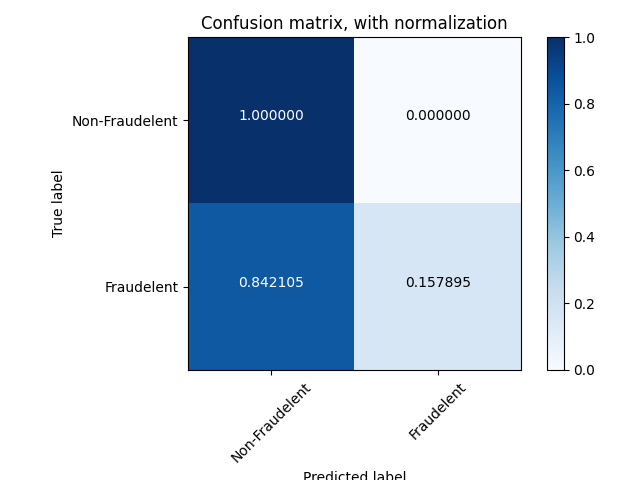

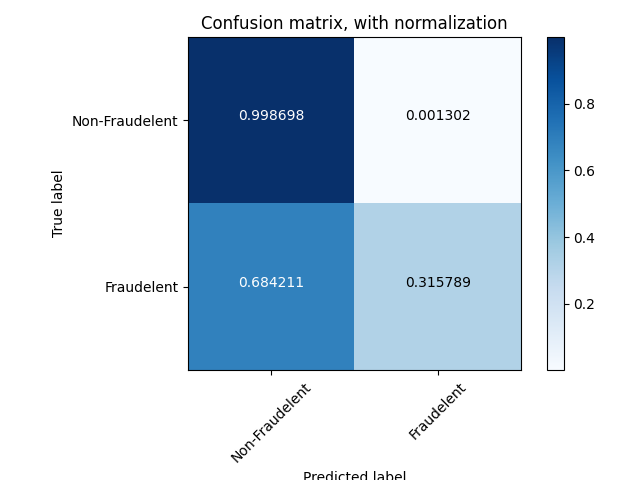

In [18]:
confMat1 = [[9981,0], [16,3]]
confMat1 = np.array(confMat1)

confMat2 = [[9968, 13], [13,6]]
confMat2 = np.array(confMat2)


import matplotlib.pyplot as plt
import itertools
%matplotlib widget
from sklearn.datasets import fetch_openml

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.6f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()
plot_confusion_matrix(confMat1, ["Non-Fraudelent","Fraudelent"],normalize=True,
                      title='Confusion matrix, with normalization')
plt.figure()
plot_confusion_matrix(confMat2, ["Non-Fraudelent","Fraudelent"],normalize=True,
                      title='Confusion matrix, with normalization')
